# Calibrate Cameras
[https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html](https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html)

In [2]:
from models.dataset.dataset_interface import DatasetInterface
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import cv2

# Rectify

In [3]:
resource_path = Path("../../resources")
uncal_path = resource_path / "images/uncalibrated"
cal_path = resource_path / "images/calibrated"
dir_to_calibrate = Path("c_dataset_d_1")

dataset_interface = DatasetInterface(uncal_path / dir_to_calibrate)

calibrated_dc = DatasetInterface(cal_path / dir_to_calibrate)

sift = cv2.SIFT_create()
index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks=50)

rectified_frames = []

for rs_rgb, rs_depth, zv_rgb, zv_depth in dataset_interface:
    zv_kp, zv_des = sift.detectAndCompute(zv_rgb, None)
    rs_kp, rs_des = sift.detectAndCompute(rs_rgb, None)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(zv_des, rs_des, k=2)

    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.7
    good_matches = [m for m,n in matches if m.distance < ratio_thresh * n.distance]

    #-- Draw matches
    # img_matches = np.empty((max(zv_rgb.shape[0], rs_rgb.shape[0]), zv_rgb.shape[1] + zv_rgb.shape[1], 3), dtype=np.uint8)
    # cv2.drawMatches(zv_rgb, zv_kp, rs_rgb, rs_kp, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    #-- Localize the object
    obj = np.empty((len(good_matches),2), dtype=np.float32)
    scene = np.empty((len(good_matches),2), dtype=np.float32)
    for i in range(len(good_matches)):
        #-- Get the keypoints from the good matches
        obj[i,0] = zv_kp[good_matches[i].queryIdx].pt[0]
        obj[i,1] = zv_kp[good_matches[i].queryIdx].pt[1]
        scene[i,0] = rs_kp[good_matches[i].trainIdx].pt[0]
        scene[i,1] = rs_kp[good_matches[i].trainIdx].pt[1]
    H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
    H_inv = np.linalg.inv(H)

    #-- Get the corners from the image_1 ( the object to be "detected" )
    # obj_corners = np.empty((4,1,2), dtype=np.float32)
    # obj_corners[0,0,0] = 0
    # obj_corners[0,0,1] = 0
    # obj_corners[1,0,0] = zv_rgb.shape[1]
    # obj_corners[1,0,1] = 0
    # obj_corners[2,0,0] = zv_rgb.shape[1]
    # obj_corners[2,0,1] = zv_rgb.shape[0]
    # obj_corners[3,0,0] = 0
    # obj_corners[3,0,1] = zv_rgb.shape[0]
    # scene_corners = cv2.perspectiveTransform(obj_corners, H)
    # #-- Draw lines between the corners (the mapped object in the scene - image_2 )
    # cv2.line(img_matches, (int(scene_corners[0,0,0] + zv_rgb.shape[1]), int(scene_corners[0,0,1])),\
    #     (int(scene_corners[1,0,0] + zv_rgb.shape[1]), int(scene_corners[1,0,1])), (0,255,0), 4)
    # cv2.line(img_matches, (int(scene_corners[1,0,0] + zv_rgb.shape[1]), int(scene_corners[1,0,1])),\
    #     (int(scene_corners[2,0,0] + zv_rgb.shape[1]), int(scene_corners[2,0,1])), (0,255,0), 4)
    # cv2.line(img_matches, (int(scene_corners[2,0,0] + zv_rgb.shape[1]), int(scene_corners[2,0,1])),\
    #     (int(scene_corners[3,0,0] + zv_rgb.shape[1]), int(scene_corners[3,0,1])), (0,255,0), 4)
    # cv2.line(img_matches, (int(scene_corners[3,0,0] + zv_rgb.shape[1]), int(scene_corners[3,0,1])),\
    #     (int(scene_corners[0,0,0] + zv_rgb.shape[1]), int(scene_corners[0,0,1])), (0,255,0), 4)
    # #-- Show detected matches

    rs_rgb_warp = cv2.warpPerspective(rs_rgb, H_inv, (zv_rgb.shape[1], zv_rgb.shape[0]))
    rs_depth_warp = cv2.warpPerspective(rs_depth, H_inv, (zv_rgb.shape[1], zv_rgb.shape[0]))

    rectified_frames.append((rs_rgb_warp, rs_depth_warp, zv_rgb, zv_depth))
    # calibrated_dc.append_and_save(rs_rgb_warp, rs_depth_warp, zv_rgb, zv_depth)

    # debug output
    # plt.figure(2)
    # plt.imshow(zv_rgb)

    # plt.figure(3)
    # plt.imshow(rs_rgb_warp)

    # img_both = cv2.addWeighted(zv_rgb, 0.5, rs_rgb_warp, 0.5, 0)
    # plt.figure(4)
    # plt.imshow(img_both)

In [4]:
for _, rs_depth, _, zv_depth in rectified_frames:
    rs_depth = np.nan_to_num(rs_depth)
    zv_depth = np.nan_to_num(zv_depth)
    print(f"rs_mean: {np.mean(rs_depth)}, zv_mean: {np.mean(zv_depth)}")

rs_mean: 2413.4530464409722, zv_mean: 347.6421813964844
rs_mean: 2437.2889487847224, zv_mean: 436.0567932128906
rs_mean: 2298.75448046875, zv_mean: 671.77685546875
rs_mean: 2564.364517795139, zv_mean: 157.3164520263672
rs_mean: 2502.5954075520835, zv_mean: 402.3384094238281
rs_mean: 2583.8365915798613, zv_mean: 144.060546875
rs_mean: 2521.1205078125, zv_mean: 234.02096557617188
rs_mean: 2486.187707465278, zv_mean: 219.21310424804688
rs_mean: 2304.8840828993057, zv_mean: 603.0956420898438
rs_mean: 2338.810203125, zv_mean: 227.52188110351562
rs_mean: 2399.8365134548612, zv_mean: 413.6538391113281
rs_mean: 2351.3763598090277, zv_mean: 491.05255126953125


# Mask

In [3]:
import os
import sys

THIRDPARTY_DIR = os.path.abspath("../../3rdparty/mask_rcnn")
sys.path.append(THIRDPARTY_DIR)  # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize, config

# Directory to save logs and trained model
MODEL_DIR = Path("../../resources/networks/mask_rcnn")

# Local path to trained weights file
COCO_MODEL_PATH = MODEL_DIR / "mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

class InferenceConfig(config.Config):
    NAME = "coco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

config = InferenceConfig()
config.display()

model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH.as_posix(), by_name=True)


/home/claudiusk/.conda/envs/depth-denoising_preprocess/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/claudiusk/.conda/envs/depth-denoising_preprocess/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/claudiusk/.conda/envs/depth-denoising_preprocess/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Using TensorFlow backend.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


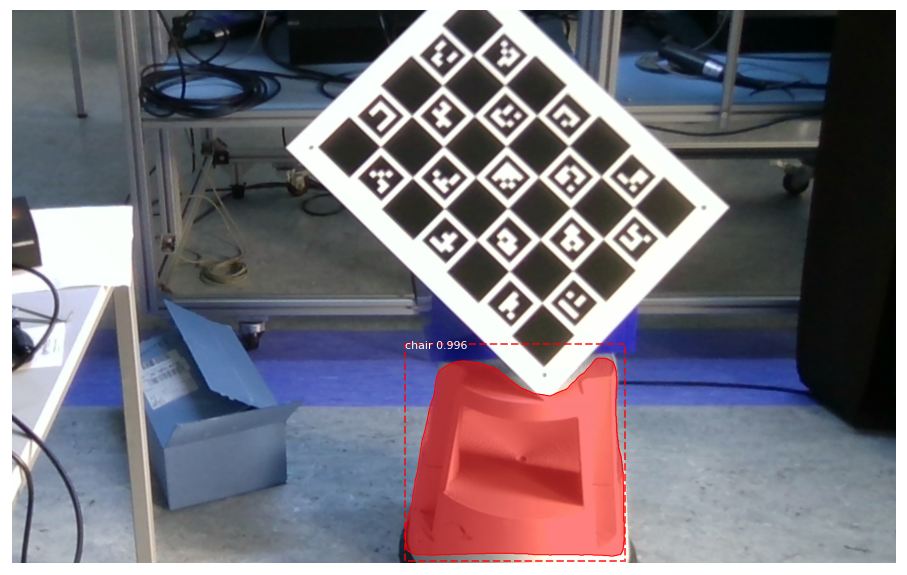

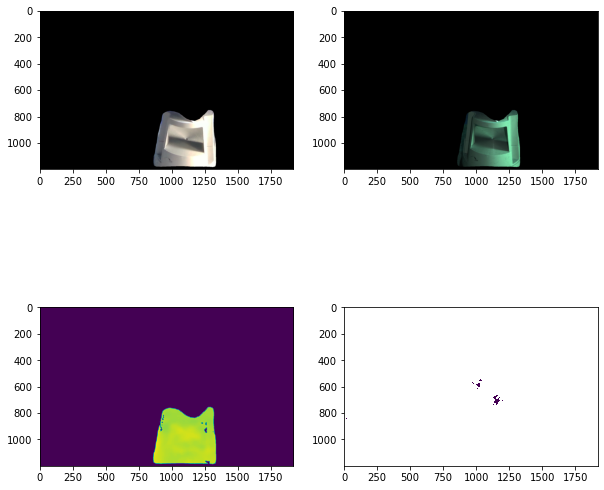

In [7]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

for rs_rgb, rs_depth, zv_rgb, zv_depth in rectified_frames:
    results = model.detect([rs_rgb])
    r = results[0]

    rs_rgb_masked = rs_rgb * r['masks']
    rs_depth_masked = np.expand_dims(rs_depth, axis=2) * r['masks']
    zv_rgb_masked = zv_rgb * r['masks']
    zv_depth_masked = np.expand_dims(zv_depth, axis=2) * r['masks']

    visualize.display_instances(rs_rgb, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])


    _, axarr = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    axarr[0][0].imshow(rs_rgb_masked)
    axarr[0][1].imshow(zv_rgb_masked)
    axarr[1][0].imshow(rs_depth_masked)
    axarr[1][1].imshow(zv_depth_masked)


    break